## Assignment 4 

In this assignment we will try to improve the inversion using some commong regulization and different objective function.

In [1]:
import time
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from scipy import signal,interpolate
from torchvision.transforms import GaussianBlur 
%matplotlib inline



## Setting the parameters

In [2]:
device = torch.device('cuda:0')


# Load the true model for forward modelling 
path = './'
velocity_file= path + 'Pluto_sc.npy' # true model 

# Define the model and achuisition parameters
par = {'nx':600,   'dx':0.01, 'ox':0,
       'nz':200,   'dz':0.01, 'oz':0,
       'ns':30,    'ds':0.1,   'osou':0,  'sz':0,
       'nr':300,   'dr':0.02,  'orec':0, 'rz':0,
       'nt':2000,  'dt':0.0015,  'ot':0,
       'freq':10,
       'num_batches':5, # increase thus number if you have a CUDA out of memory error 
        'FWI_itr': 100
      }

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]
    
fs = 1/dt # sampling frequency


# Don't change the below two lines 
num_sources_per_shot=1
num_dims = 2 



## The acquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [3]:

x_s = torch.zeros(ns, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(ns).float() * ds  
x_s[:, 0, 0] = sz

x_r = torch.zeros(ns, nr, num_dims)
x_r[0, :, 1] = torch.arange(nr).float() * dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(ns, 1)
x_r[:, :, 0] = rz





## Create source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use any function to create the wavelet but it needs to be converted to tensor. 

torch.Size([2000, 30, 1])


Text(0.5, 0, 'Time (s)')

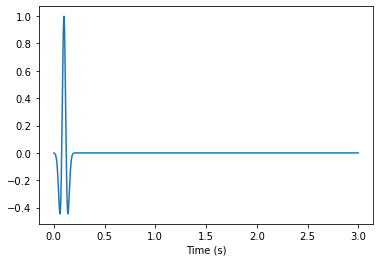

In [4]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, ns, num_sources_per_shot))
print(source_wavelet.shape)


plt.plot(np.arange(0,nt)*dt,source_wavelet[:,0,0])
plt.xlabel('Time (s)')

### Create the velocity model 


In [5]:
vel_true = np.zeros((nz,nx))

# True velocity 
vel_true[:int(nz//1.5),] = 2 # 1st layer
vel_true[int(nz//1.5):,] = 3 # 2nd layer

# Initial model 
vel_init = vel_true.copy()


vel_true[50:100,250:350] = 2.5 # add anomaly to the true 


# Mask 
msk = np.ones_like(vel_true)
msk[:20,:] = 0 


# Convert to tensor 
vel_true = torch.Tensor(vel_true) 
vel_init = torch.Tensor(vel_init) 
msk = torch.Tensor(msk) 



# Make a copy so at the end we can see how far we came from the initial model
vel = vel_init.clone()
vel = vel.to(device)
vel.requires_grad = True


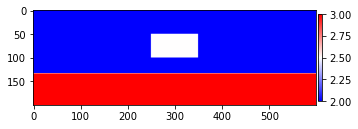

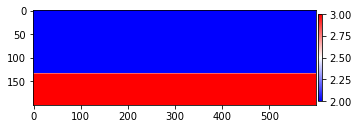

In [6]:
#plot true
plt.figure()
plt.imshow(vel_true,cmap='bwr',vmin=2,vmax=3)
plt.colorbar(shrink=0.4,pad=0.005)

#Plot init
plt.figure()
plt.imshow(vel_init,cmap='bwr',vmin=2,vmax=3)
plt.colorbar(shrink=0.4,pad=0.005)

## Forward modeling 

In [7]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': vel_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

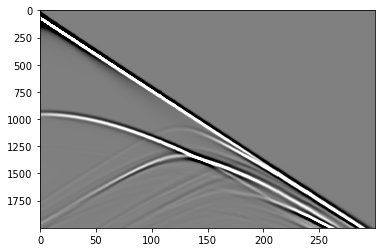

In [8]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,0].cpu().numpy(), [2,98])

plt.imshow(data_true[:,0,].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



##  Set the optimizer and the criterion 


In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [vel], 'lr': 0.01}])

## Main inversion loop 

Epoch: 0 Loss:  1.1626842982045537e-13


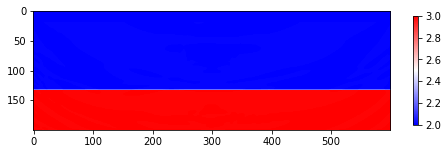

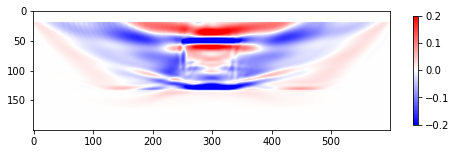

Epoch: 1 Loss:  9.898427699240112e-14
Epoch: 2 Loss:  8.914346853999139e-14
Epoch: 3 Loss:  8.317074276736978e-14
Epoch: 4 Loss:  7.73906627801399e-14
Epoch: 5 Loss:  7.094142168238143e-14
Epoch: 6 Loss:  6.423768614748863e-14
Epoch: 7 Loss:  5.828672319238082e-14
Epoch: 8 Loss:  5.412974044417384e-14
Epoch: 9 Loss:  5.16589283963741e-14
Epoch: 10 Loss:  4.940513550702333e-14


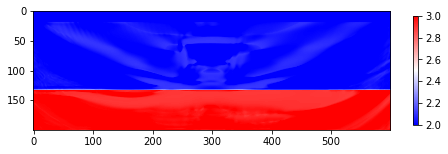

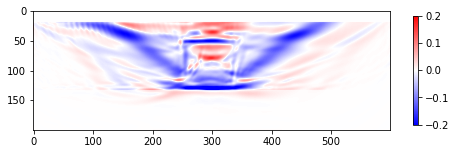

Epoch: 11 Loss:  4.668179159742804e-14
Epoch: 12 Loss:  4.389822449231591e-14
Epoch: 13 Loss:  4.159337076283876e-14
Epoch: 14 Loss:  3.9882397243670015e-14
Epoch: 15 Loss:  3.849717904348812e-14
Epoch: 16 Loss:  3.7139360665084005e-14
Epoch: 17 Loss:  3.573431511767278e-14
Epoch: 18 Loss:  3.4420576757360254e-14
Epoch: 19 Loss:  3.335309840338534e-14
Epoch: 20 Loss:  3.251409532847101e-14


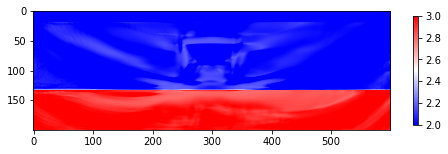

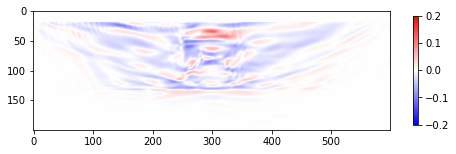

Epoch: 21 Loss:  3.172045256194804e-14
Epoch: 22 Loss:  3.082398550134256e-14
Epoch: 23 Loss:  2.984272451348629e-14
Epoch: 24 Loss:  2.8895807323509395e-14
Epoch: 25 Loss:  2.8081298747363766e-14
Epoch: 26 Loss:  2.7380034664617773e-14
Epoch: 27 Loss:  2.672409446784641e-14
Epoch: 28 Loss:  2.6068200857887148e-14
Epoch: 29 Loss:  2.5423161551630475e-14
Epoch: 30 Loss:  2.4833172610681754e-14


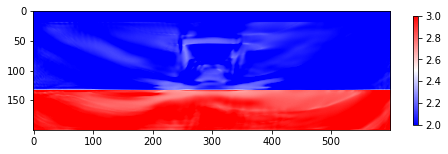

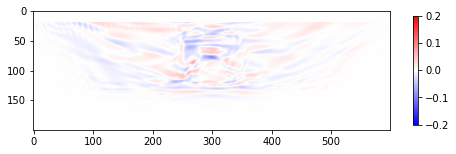

Epoch: 31 Loss:  2.4318030889084212e-14
Epoch: 32 Loss:  2.3856254360746058e-14
Epoch: 33 Loss:  2.3402238771787123e-14
Epoch: 34 Loss:  2.293807572812008e-14
Epoch: 35 Loss:  2.2476427101756962e-14
Epoch: 36 Loss:  2.2043388707253253e-14
Epoch: 37 Loss:  2.1643356222088728e-14
Epoch: 38 Loss:  2.1271332575391062e-14
Epoch: 39 Loss:  2.09110221238045e-14
Epoch: 40 Loss:  2.0551895400761728e-14


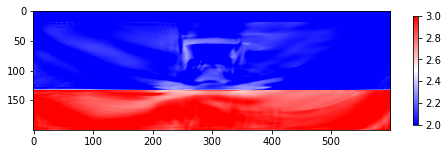

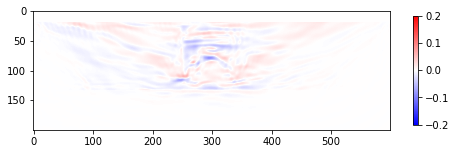

Epoch: 41 Loss:  2.0192257069818814e-14
Epoch: 42 Loss:  1.9843626355541943e-14
Epoch: 43 Loss:  1.9519670134535063e-14
Epoch: 44 Loss:  1.9205514084727916e-14
Epoch: 45 Loss:  1.8889720296717252e-14
Epoch: 46 Loss:  1.8571329082173833e-14
Epoch: 47 Loss:  1.8260993786233513e-14
Epoch: 48 Loss:  1.7960053144469427e-14
Epoch: 49 Loss:  1.76689162737951e-14
Epoch: 50 Loss:  1.7381061232274908e-14


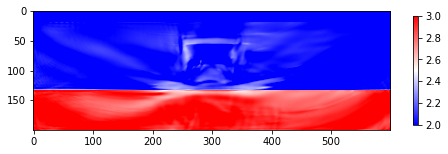

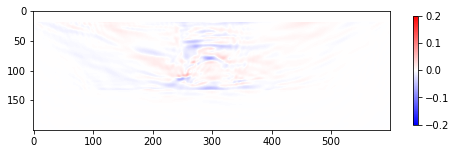

Epoch: 51 Loss:  1.709319200295285e-14
Epoch: 52 Loss:  1.681295009356258e-14
Epoch: 53 Loss:  1.6545449042006674e-14
Epoch: 54 Loss:  1.6287900627581006e-14
Epoch: 55 Loss:  1.6035892232146853e-14
Epoch: 56 Loss:  1.5785359791623292e-14
Epoch: 57 Loss:  1.554170165874141e-14
Epoch: 58 Loss:  1.530196232379e-14
Epoch: 59 Loss:  1.5066785531808974e-14
Epoch: 60 Loss:  1.483163457433284e-14


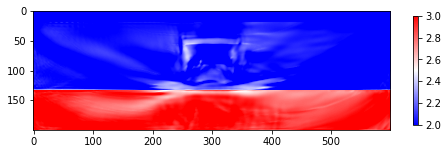

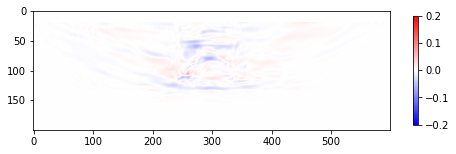

Epoch: 61 Loss:  1.4607174654958713e-14
Epoch: 62 Loss:  1.4392676478319007e-14
Epoch: 63 Loss:  1.418229001136351e-14
Epoch: 64 Loss:  1.3976207107054776e-14
Epoch: 65 Loss:  1.377323048432186e-14
Epoch: 66 Loss:  1.3577358138675802e-14
Epoch: 67 Loss:  1.3385803331720137e-14
Epoch: 68 Loss:  1.320027749352479e-14
Epoch: 69 Loss:  1.3017833161191555e-14
Epoch: 70 Loss:  1.2842839754178843e-14


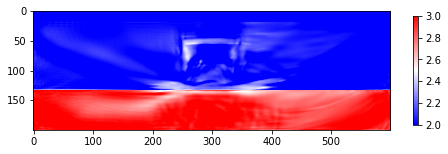

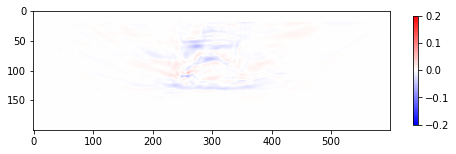

Epoch: 71 Loss:  1.2677642283201126e-14
Epoch: 72 Loss:  1.252115718136063e-14
Epoch: 73 Loss:  1.2371766192211626e-14
Epoch: 74 Loss:  1.2227804896012759e-14
Epoch: 75 Loss:  1.2089996023626273e-14
Epoch: 76 Loss:  1.195880734899729e-14
Epoch: 77 Loss:  1.1832130395361858e-14
Epoch: 78 Loss:  1.1711043647420066e-14
Epoch: 79 Loss:  1.1596203979222512e-14
Epoch: 80 Loss:  1.1483765437672187e-14


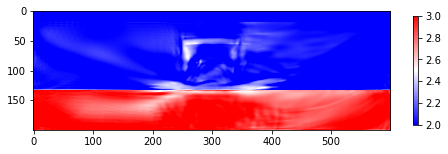

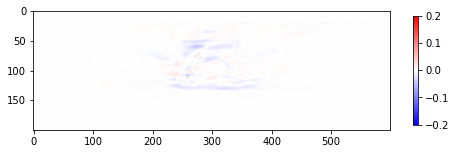

Epoch: 81 Loss:  1.13778863192654e-14
Epoch: 82 Loss:  1.1274201439708475e-14
Epoch: 83 Loss:  1.1176097024966298e-14
Epoch: 84 Loss:  1.1080801159718979e-14
Epoch: 85 Loss:  1.0988193353529772e-14
Epoch: 86 Loss:  1.090120476391265e-14
Epoch: 87 Loss:  1.0814356781764772e-14
Epoch: 88 Loss:  1.0732535304884138e-14
Epoch: 89 Loss:  1.0651832758526826e-14
Epoch: 90 Loss:  1.0572953662346717e-14


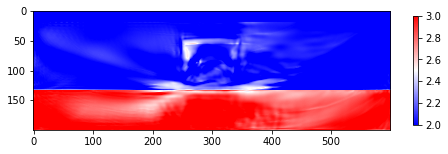

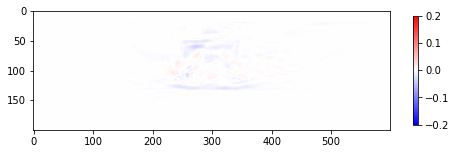

Epoch: 91 Loss:  1.0500143768991921e-14
Epoch: 92 Loss:  1.0426583404445858e-14
Epoch: 93 Loss:  1.0356711444868614e-14
Epoch: 94 Loss:  1.0287487041979546e-14
Epoch: 95 Loss:  1.022160058417737e-14
Epoch: 96 Loss:  1.0156561371080686e-14
Epoch: 97 Loss:  1.0094485079233497e-14
Epoch: 98 Loss:  1.0033480495822821e-14
Epoch: 99 Loss:  9.975406222893172e-15
Runtime: 4.065583860874176 minutes


In [10]:
# Iterative inversion loop
num_shots_per_batch = int(ns / num_batches)
epoch_loss = []
updates = []
gradients = []
msk = msk.to(device)



t_start = time.time()
for epoch in range(FWI_itr):
  running_loss=0
  optimizer.zero_grad()
  for it in range(num_batches):
    prop = deepwave.scalar.Propagator({'vp': vel}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
    batch_data_true = data_true[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
    loss = criterion(data_pred, batch_data_true)
    running_loss += loss.item()
    loss.backward()
  epoch_loss.append(running_loss)     

  # Apply some operations to the gradient
  if epoch==0: gmax = torch.abs(model.grad).max()
  model.grad = model.grad / gmax  * msk  # normalizing by the first gradient and mask the wter layer
    

  # update the vel 
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)

  # save the vel updates and gradients for each iteration
  updates.append(vel.detach().clone().cpu().numpy())
  gradients.append(vel.grad.cpu().detach().numpy())  
    
  # plotting every 10 itr   
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(vel.cpu().detach().numpy(), vmin=2, vmax=3,
               cmap='bwr')
    plt.colorbar(shrink=0.5)
    plt.show()   

    plt.figure(figsize=(8, 4))
    gr = vel.grad.cpu().detach().numpy()
    g_min, g_max = np.percentile(gr, [2,98]) 
    plt.imshow(gr, cmap='bwr',vmin=-0.2,vmax=0.2)
    plt.colorbar(shrink=0.5)
    plt.show()
    
t_end = time.time()
print('Runtime:', (t_end - t_start)/60 ,'minutes')

In [13]:
updates = np.array(updates)
gradients = np.array(gradients)
obj = np.array(epoch_loss)

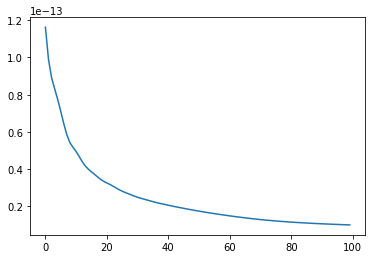

In [14]:
plt.plot(obj)